# 6. Principal Component Analysis

Vamos a emplear el algoritmo de PCA en imágenes para reducir su dimensionalidad.

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import linalg
%matplotlib inline

# Default figure size
plt.rcParams['figure.figsize'] = (12,8)

In [4]:
if not os.path.exists('lfwcrop_grey'):
    !wget http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip
    !unzip 'lfwcrop_grey.zip'

filenames = []
images = []

for filename in os.listdir('lfwcrop_grey/faces'):
    filenames.append(filename)
    image = np.array(Image.open(os.path.join('lfwcrop_grey/faces', filename)))
    images.append(image)

images = np.array(images)

# Rotate each image 90 degrees to the right
images = np.rot90(images, k=1, axes=(1,2))

print('Total Number of Faces: {}'.format(len(images)))
print(images.shape)

X = images.reshape(13233, 64*64)
print(X.shape)

'wget' is not recognized as an internal or external command,
operable program or batch file.


'unzip' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfwcrop_grey/faces'

El dataset se compone de 5000 imágenes de 64x64 píxeles en escala de grises, cada una de ellas representada como un vector de 1024 dimensiones.

En cada imagen se muestra la cara de una persona, centrada y ocupando la mayor parte de la imagen.

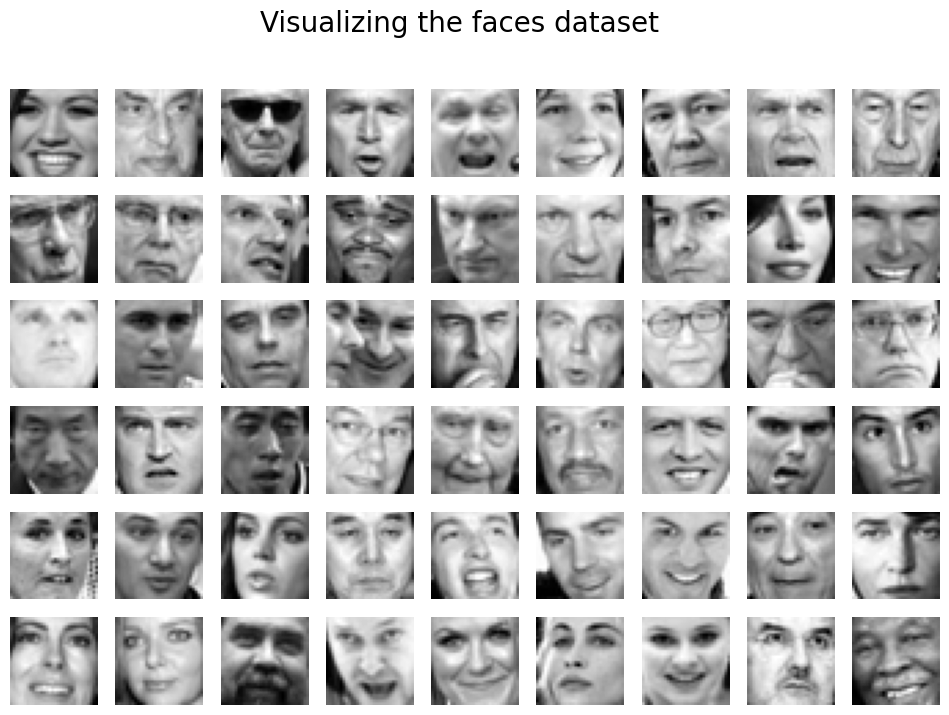

In [259]:
# Visualizing the face images
fig = plt.figure()
fig.suptitle("Visualizing the faces dataset",fontsize = 20)
indices = np.random.choice(X.shape[0],54)
for i in range(54):
    img = X[indices[i]].reshape(64,64,order ='F')
    fig.add_subplot(6,9,i+1)
    plt.imshow(img,cmap = 'gray')
    plt.axis("off")
    
plt.show()


### Normalización de los datos

A todos los efectos, podemos interpretar que tenemos 5000 ejemplos de entrenamiento, cada uno de ellos con 1024 características, una por cada píxel de la imagen.

In [260]:
# Function for mean normalizing and feature scaling 
def featureNormalize(X,mu,sigma):
    X_norm = np.apply_along_axis(np.subtract,1,X,mu)
    X_norm = np.apply_along_axis(np.divide,1,X_norm,sigma)
    return X_norm

In [261]:
# Obtaining a normalized version of X 
mu = np.mean(X,axis =0)
sigma = np.std(X,axis =0)
X_norm = featureNormalize(X,mu,sigma)

print("mu.shape:", mu.shape)
print("sigma.shape:", sigma.shape)
print("X_norm.shape:", X_norm.shape)

mu.shape: (1024,)
sigma.shape: (1024,)
X_norm.shape: (5000, 1024)


### Obtención de los componentes principales

Vamos a calcular los componentes principales de los datos. 

Primero calculamos la matriz de covarianza de los datos.

A continuación calculamos los autovalores y autovectores de la matriz de covarianza, para ello usamos la función de numpy `np.linalg.svd`.

Esta función realiza SVD (Singular Value Decomposition) y devuelve los autovalores en orden descendente. Más explicación en los siguientes enlaces de la librería [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) y el siguiente [Blog](https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d).

In [262]:
# Function to run PCA on the dataset
def pca(X):
    m,n = X.shape
    Sigma = (1.0/m) * ((X.T).dot(X))
    U,S,V = linalg.svd(Sigma)
    
    return U,S 

In [263]:
# Runs PCA and obtains Eigenvectors U and eigenvalues S
U,S = pca(X_norm)
U.shape

(1024, 1024)

Podemos visualizar los primeros 42 autovectores, los cuales representan las direcciones principales de variación de los datos.

Cada autovector representa una dirección en el espacio de 1024 dimensiones, y cada dirección representa una combinación lineal de los píxeles originales.

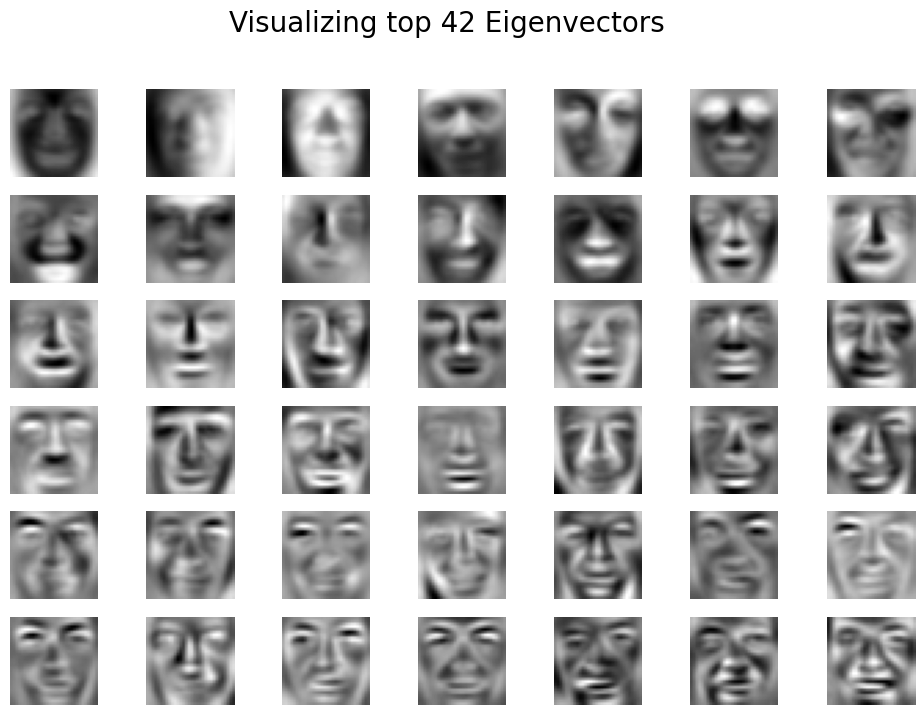

In [264]:
# Visualizing top 42 Eigenvectors
fig = plt.figure()
fig.suptitle("Visualizing top 42 Eigenvectors",fontsize = 20)
for i in range(42):
    img = U[:,i].reshape(64,64,order= 'F')
    fig.add_subplot(6,7,i+1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
plt.show()

A continuación, proyectamos los datos sobre los dos primeros autovectores.

Reduciremos la dimensión de cada imagen de 1024 a 100, proyectando cada imagen sobre los primeros 100 autovectores.

In [265]:
# Function computes the reduced dimension data using the top K eigenvectors in U
# The data gets projected to K dimensions
def projectData(X,U,K):
    U_reduce = U[:,:K]
    Z = X.dot(U_reduce)
    return Z

In [266]:
# Reducing the dimension of the data to only 100 using PCA, reduced dimension data is stored in Z
# Hence each face image is now described by only 100 features instead of 1024
K = 100
Z = projectData(X_norm,U,K)
Z.shape

(5000, 100)

In [267]:
# Function to reconstruct an approximation to the original dataset 
# using data that has been reduced to K dimensions
def recoverData(Z,U,K):
    U_reduce = U[:,:K]
    X_rec = Z.dot(U_reduce.T)
    return X_rec    

In [268]:
# Reconstructing the original data
X_rec = recoverData(Z,U,K)

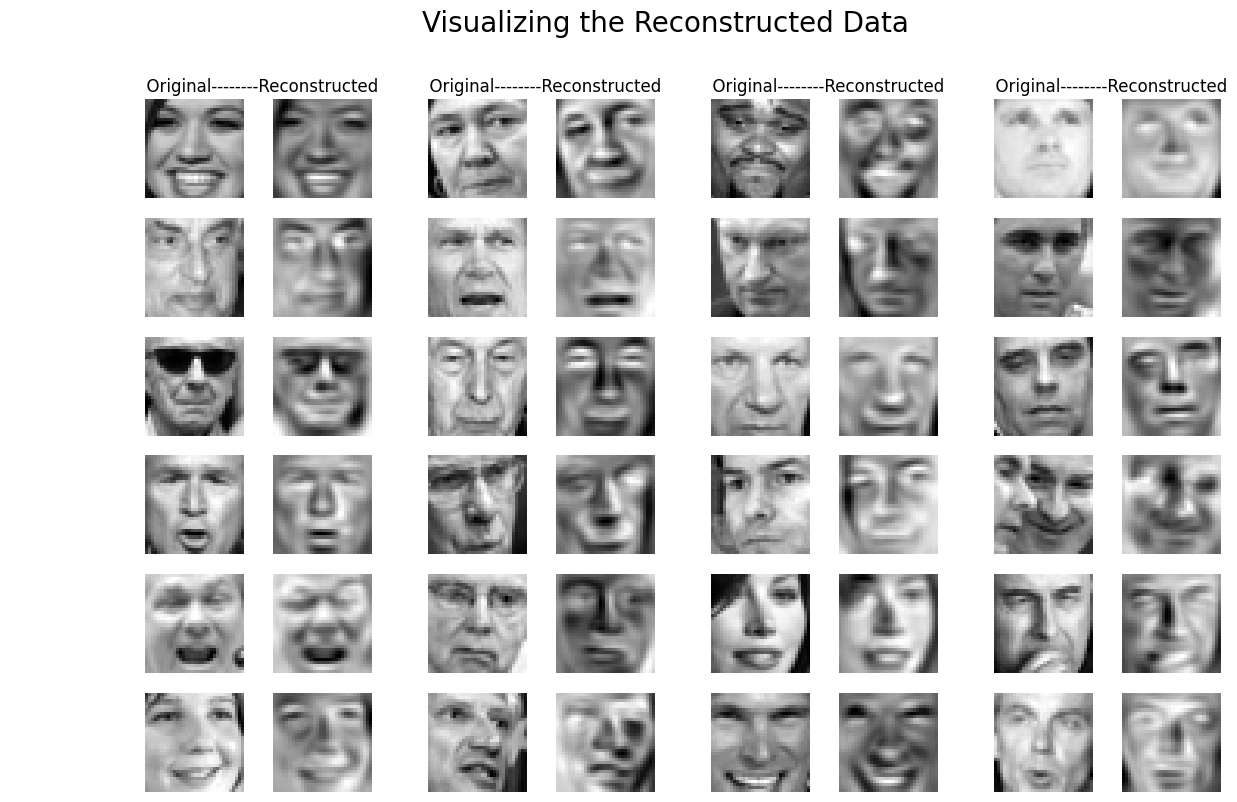

In [269]:
# Visualizing the reconstructed data
k = 0
fig = plt.figure(figsize=(14,9))
fig.suptitle("Visualizing the Reconstructed Data",fontsize = 20)
outer = gridspec.GridSpec(1,4)
for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(6,2,
            subplot_spec = outer[i])
    for j in range(12):
        ax = plt.Subplot(fig,inner[j])
        if j == 0:
            ax.set_title("                          Original--------Reconstructed")
        if j%2 == 0:
            img = X[indices[k]].reshape(64,64,order='F')
            
        else:
            img = X_rec[indices[k]].reshape(64,64,order='F')
            k = k+1
            
        ax.imshow(img,cmap='gray')
        ax.axis('off')
        fig.add_subplot(ax)

Se realiza una recuperación aproximada de los datos y se muestran una junto a otra las imágenes del rostro original y las proyectadas. A partir de la reconstrucción, podemos observar que se mantienen la estructura general y el aspecto del rostro, mientras que se pierden los detalles finos. Se trata de una notable reducción con un factor de 10.